## Random Forest, Gradient, Light, XG & Adaptative Boosting_K40_06NOV2020_35municp

### Carregando as Bibliotecas

In [224]:
! pip install lightgbm
! pip install xgboost

In [225]:
import plotly_express as px
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats
import scipy
import seaborn as sns
import statsmodels
import statsmodels.stats.api as sms

In [226]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [227]:
# parâmetros dos gráficos para o arquivo
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
%matplotlib inline
plt.rcParams.update(params)

### Arquivo_02

In [228]:
df=pd.read_csv('d_f_a_2.csv',encoding = "ISO-8859-1", sep=";", low_memory=False, nrows=1000000)

In [229]:
df.shape

(140628, 83)

In [230]:
# separação na doença mais frequente desse arquivo = K40
temp = np.where(df['diag_princ'].isin(['K40']))
df40 = df.loc[temp]
# reunir tudo
df40.head(3)

,cod_muni,qtd_mora,incidencia,diag_princ,prevalencia,renda_media_mora,SITU1_entorno,SITU2_entorno,SITU3_entorno,SITU4_entorno,...,V032_domicilio02,V033_domicilio02,V034_domicilio02,V035_domicilio02,V036_domicilio02,V037_domicilio02,V038_domicilio02,V041_domicilio02,V045_domicilio02,V089_domicilio02
18,290010,8301,24,K40,0.002891,0.103943,0.463481,0.0,0.0,0.0,...,0.005892,0.399110,0.016835,0.035354,0.000000,0.010582,0.970779,0.027417,0.490861,0.509139
53,290020,16991,50,K40,0.002943,0.036980,0.548910,0.0,0.0,0.0,...,0.109294,0.194620,0.004395,0.249180,0.000176,0.024848,0.909341,0.086381,0.501875,0.498125
98,290030,14503,97,K40,0.006688,0.063205,0.887555,0.0,0.0,0.0,...,0.006756,0.374053,0.024022,0.037399,0.000409,0.006142,0.970859,0.018904,0.491913,0.508087


In [231]:
df40.shape

(2409, 83)

In [232]:
# Preparação dos arquivos de entrada (X) e saída (y)
X = df40.drop(columns=['prevalencia','diag_princ','incidencia'])
y = df40.loc[:,'prevalencia']

In [233]:
# Divisão entre arquivos de treino e teste, com corte em 30%
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.3, random_state=1234)

In [234]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(n_estimators=100)
model.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)

<AxesSubplot:>

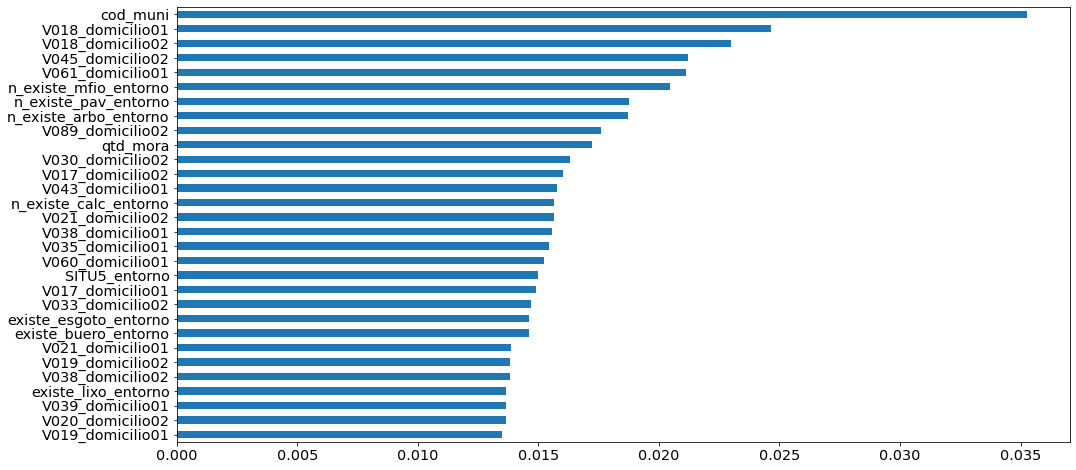

In [235]:
(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(30).sort_values().plot.barh())

### Seleção de atributos  - acima da importância de (não_exixte_pav_entorno): vide acima

In [236]:
# Preparação dos arquivos de entrada (X) e saída (y)
# Código do município foi retirado
X = df40[["cod_muni","V018_domicilio02",'V018_domicilio01',"V061_domicilio01",'V045_domicilio02',"V089_domicilio02","n_existe_mfio_entorno",
           'n_existe_arbo_entorno',"n_existe_pav_entorno"]]
y = df40.loc[:,'prevalencia']

In [237]:
# Divisão entre arquivos de treino e teste, com corte em 30%
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.3, random_state=1234)

### Algoritmo Referência = Random Forest

In [238]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [239]:
params_grid= {'n_estimators':[2,3,4,5,6,7,8,9,10],
              "max_features":['auto'],
              'max_depth':[10,20,30],
              'max_leaf_nodes':[2,3,4,5],
              'min_samples_leaf':[5,10,15],
              'min_samples_split':[3,6,9,12,15,18,21]}
random_rf = RandomizedSearchCV(estimator = rf,cv=10,param_distributions=params_grid,n_iter=100,verbose=2,n_jobs=-1)
random_rf.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   15.2s finished
C:\Users\aferr\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_st...


In [240]:
random_rf.best_params_

{'n_estimators': 6,
 'min_samples_split': 12,
 'min_samples_leaf': 15,
 'max_leaf_nodes': 5,
 'max_features': 'auto',
 'max_depth': 10}

In [241]:
m_rf=RandomForestRegressor(n_estimators= 9,
 min_samples_split = 9,
 min_samples_leaf = 15,
 max_leaf_nodes = 5,
 max_features ='auto',
 max_depth = 20)

In [242]:
yrf = m_rf.fit(X_train,y_train)
print(yrf)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=5,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=15, min_samples_split=9,
                      min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=None,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)


In [243]:
y_rf= yrf.predict(X_test)

In [244]:
mse_rf = round(mean_squared_error(y_test, y_rf),8)
print(mse_rf)

4.68e-06


In [245]:
errop2= (y_test - y_rf)*100/y_test
# em porcentagem
media = round(np.mean(errop2),1)
print(media)
desvio = round(np.std(errop2),1)
print(desvio)

-23.5
63.3


### Identificação dos municípios com errop2 entre -3 e 3 porcento

In [246]:
errop2.shape

(723,)

In [247]:
print(errop2)

28093     -19.965406
60506    -112.912464
110943     34.438811
109620     -0.419757
124632    -79.572240
             ...    
36559     -14.365720
110742     25.598285
83532       1.619854
59033       3.031058
29783     -36.629485
Name: prevalencia, Length: 723, dtype: float64


In [248]:
print(type(errop2))

<class 'pandas.core.series.Series'>


In [249]:
frame = { 'cod_muni': X_test['cod_muni'], "errop2": errop2 } 
result = pd.DataFrame(frame) 
print(result) 

        cod_muni      errop2
28093     310840  -19.965406
60506     315800 -112.912464
110943    355460   34.438811
109620    355290   -0.419757
124632    431030  -79.572240
...          ...         ...
36559     312210  -14.365720
110742    355430   25.598285
83532     351800    1.619854
59033     315590    3.031058
29783     311110  -36.629485

[723 rows x 2 columns]


In [250]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 723 entries, 28093 to 29783
Data columns (total 2 columns):
cod_muni    723 non-null int64
errop2      723 non-null float64
dtypes: float64(1), int64(1)
memory usage: 16.9 KB


In [251]:
a=result[result['errop2'] >-3]

In [252]:
a.head(3)

,cod_muni,errop2
110943,355460,34.438811
109620,355290,-0.419757
65387,316570,51.741419


In [253]:
a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341 entries, 110943 to 59033
Data columns (total 2 columns):
cod_muni    341 non-null int64
errop2      341 non-null float64
dtypes: float64(1), int64(1)
memory usage: 8.0 KB


In [254]:
b_rf=a[a['errop2'] <3]

In [255]:
b_rf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 109620 to 83532
Data columns (total 2 columns):
cod_muni    50 non-null int64
errop2      50 non-null float64
dtypes: float64(1), int64(1)
memory usage: 1.2 KB


In [256]:
b.head(35)

,cod_muni,errop2
79086,351220,-1.366356
83426,351780,-0.277848
88296,352380,1.000170
81258,351510,-0.797354
54635,314880,-0.994240
120717,430655,1.730246
93047,353020,-1.498908
136284,432000,0.336745
746,290130,-0.596848
98420,353760,-1.338822


### Há 35 municípios onde o erro situa-se entre -3 & 3 porcento -- Random Forest

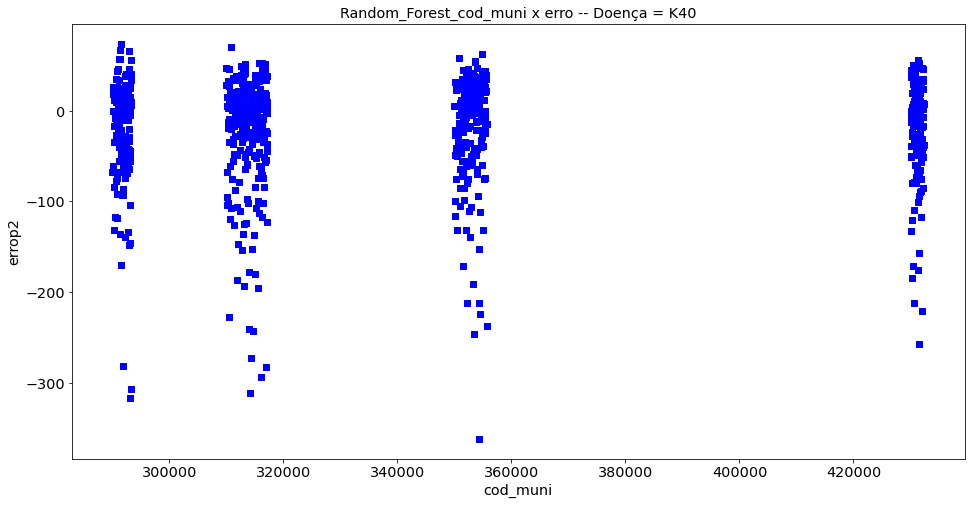

In [257]:
plt.scatter(X_test['cod_muni'], errop2, c = "blue", marker = "s")
plt.title("Random_Forest_cod_muni x erro -- Doença = K40")
plt.xlabel("cod_muni")
plt.ylabel("errop2")
plt.show()

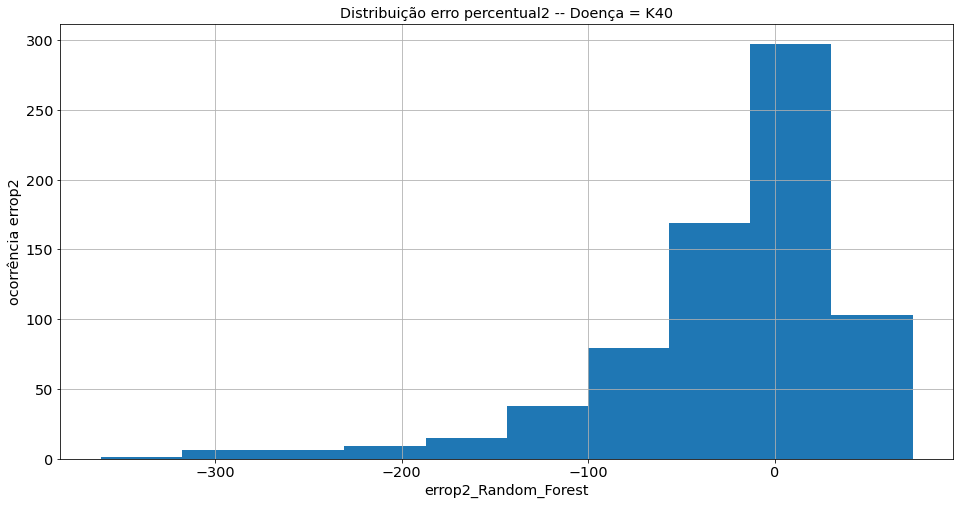

In [258]:
errop2.hist()
plt.title("Distribuição erro percentual2 -- Doença = K40")
plt.xlabel("errop2_Random_Forest")
plt.ylabel("ocorrência errop2")
plt.show()

### Uso inicial dos algoritmos GBoosting

### Otimização de parâmetros

In [259]:
# Light & XG Boosting
params= {
    'booster': ["gbtree","gblinear",'dart'],
    'learning rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max depth': [3,4,5,8,10,11,12],
    'min_child_weigth': [1,3,5,7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3,0.4,0.5,0.6]
}

In [260]:
# Gradient Boosting
params0= {
    'min_samples_split': [300,400,500],
    'min_samples_leaf': [30,40,50],
    'min_weight_fraction_leaf': [0, 0.1, 0.2, 0.3, 0.4],
    'max_depth': [5,6,7,8],
    'subsample': [0.6,0.7,0.8],
    'learning_rate' : [0.09, 0.1, 0.15]
}

In [261]:
# Adaptative Boosting
params1= {
    'n_estimators': [30,40,50],
    'learning_rate' : [0.09, 0.1, 0.15]
}

In [262]:
# GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X_train, y_train)
import lightgbm as lgb
lgb = lgb.LGBMRegressor(learning_rate = 0.001, 
                              num_leaves = 65,  
                              n_estimators = 100)                       
lgb.fit(X_train, y_train)
 # XGBoost
import xgboost as xgb
xgb= xgb.XGBRegressor(learning_rate=0.001,
                            max_depth = 1, 
                            n_estimators = 100)
xgb.fit(X_train, y_train)
# AdaBoost
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
ada = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=1), n_estimators=100,
    learning_rate=0.001)
ada.fit(X_train, y_train)

print('*****************ClassifiersDone*****************')

*****************ClassifiersDone*****************


In [263]:
# Random Search & Cross Validation
random_search_gbr = RandomizedSearchCV(gbr,param_distributions=params0,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search_lgb = RandomizedSearchCV(lgb,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search_xgb = RandomizedSearchCV(xgb,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search_ada = RandomizedSearchCV(ada,param_distributions=params1,n_iter=5,n_jobs=-1,cv=5,verbose=3)

In [264]:
random_search_gbr.fit(X_train, y_train)
random_search_lgb.fit(X_train, y_train)
random_search_xgb.fit(X_train, y_train)
random_search_ada.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.8s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    1.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.6s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
C:\Users\aferr\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    5.1s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   11.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[23:34:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, learning rate, max depth, max_delta_step, max_depth, min_child_weight, min_child_weigth, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    4.4s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                                                    max_depth=1,
                                                                                    max_features=None,
                                                                                    max_leaf_nodes=None,
                                                                                    min_impurity_decrease=0.0,
                                                                                    min_impurity_split=None,
                                                                                    min_samples_leaf=1,
                                                                                    min_samples_split=2,
                                                                                    min_weight_fraction_lea

In [265]:
print(random_search_gbr.best_estimator_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.09, loss='ls', max_depth=6,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=40, min_samples_split=500,
                          min_weight_fraction_leaf=0.1, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.6, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)


In [266]:
print(random_search_lgb.best_estimator_)

LGBMRegressor(booster='gblinear', boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.5, gamma=0, importance_type='split',
              learning rate=0.1, learning_rate=0.001, max depth=3, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_child_weigth=5,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=65,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)


In [267]:
print(random_search_xgb.best_estimator_)

XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning rate=0.2, learning_rate=0.001, max depth=10,
             max_delta_step=0, max_depth=1, min_child_weight=1,
             min_child_weigth=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


In [268]:
print(random_search_ada.best_estimator_)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=1,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.09, loss='linear', n_estimators=30,
                  random_

In [269]:
from sklearn.model_selection import cross_val_score
score_gbr=cross_val_score(gbr,X,y,cv=10)
score_lgb=cross_val_score(lgb,X,y,cv=10)
score_xgb=cross_val_score(xgb,X,y,cv=10)
score_ada=cross_val_score(ada,X,y,cv=10)

### Gradient Boosting

In [270]:
m_gbr = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=40, min_samples_split=400,
                          min_weight_fraction_leaf=0.1, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.7, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [271]:
m_gbr.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=40, min_samples_split=400,
                          min_weight_fraction_leaf=0.1, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.7, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [272]:
y_pred_gbr = m_gbr.predict(X_test)

In [273]:
mse_gbr = round(mean_squared_error(y_test, y_pred_gbr),8)
print(mse_gbr)

4.67e-06


In [274]:
errop2= (y_test - y_pred_gbr)*100/y_test
# em porcentagem

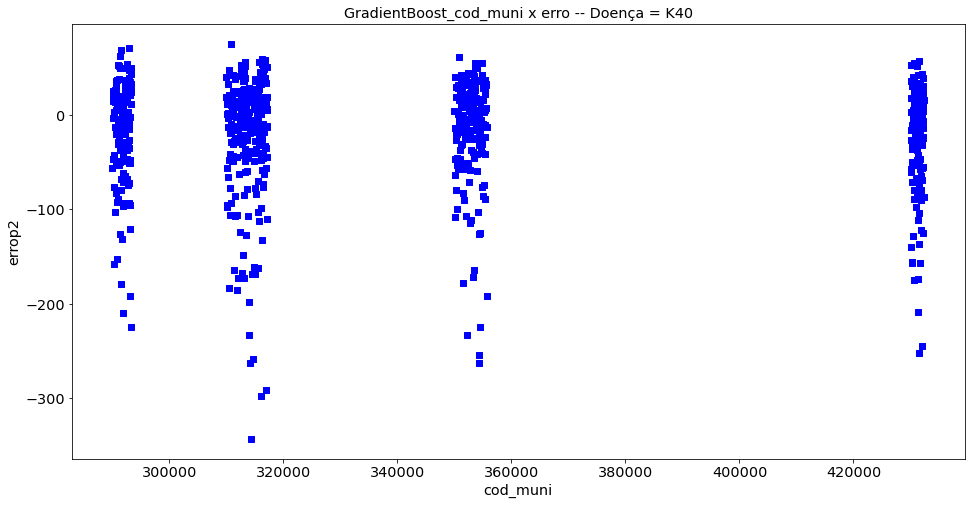

In [275]:
plt.scatter(X_test['cod_muni'], errop2, c = "blue", marker = "s")
plt.title("GradientBoost_cod_muni x erro -- Doença = K40")
plt.xlabel("cod_muni")
plt.ylabel("errop2")
plt.show()

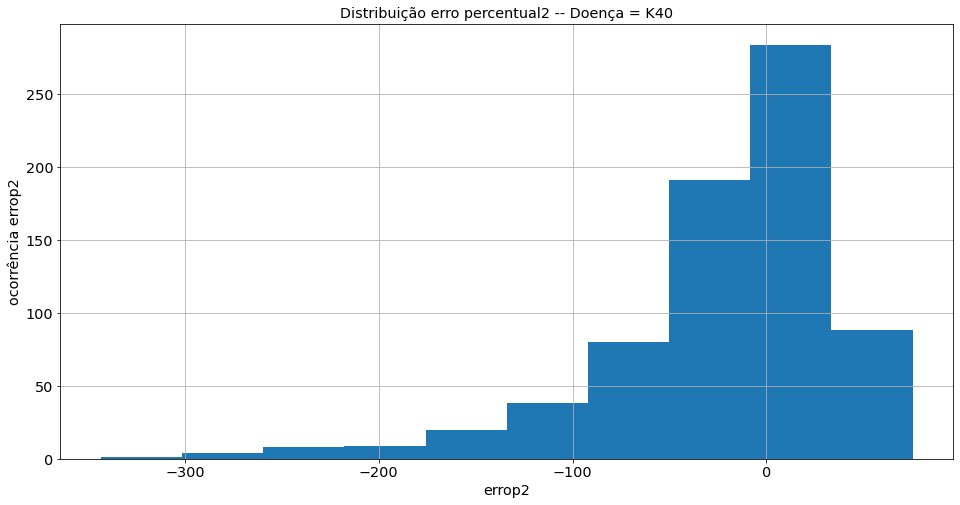

In [276]:
errop2.hist()
plt.title("Distribuição erro percentual2 -- Doença = K40")
plt.xlabel("errop2")
plt.ylabel("ocorrência errop2")
plt.show()

### Light Gradient Boosting

In [277]:
from lightgbm import LGBMRegressor
m_lgb = LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.4, gamma=0.3, importance_type='split',
              learning_rate=0.1, max_depth=8,
              min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=65,
              objective='regression', random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [278]:
m_lgb.fit(X_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
              gamma=0.3, importance_type='split', learning_rate=0.1,
              max_depth=8, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=65,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [279]:
y_pred_lgb = m_lgb.predict(X_test)

In [280]:
mse_lgb = round(mean_squared_error(y_test, y_pred_lgb),8)
print(mse_lgb)

4.86e-06


In [281]:
errop2= (y_test - y_pred_lgb)*100/y_test
# em porcentagem

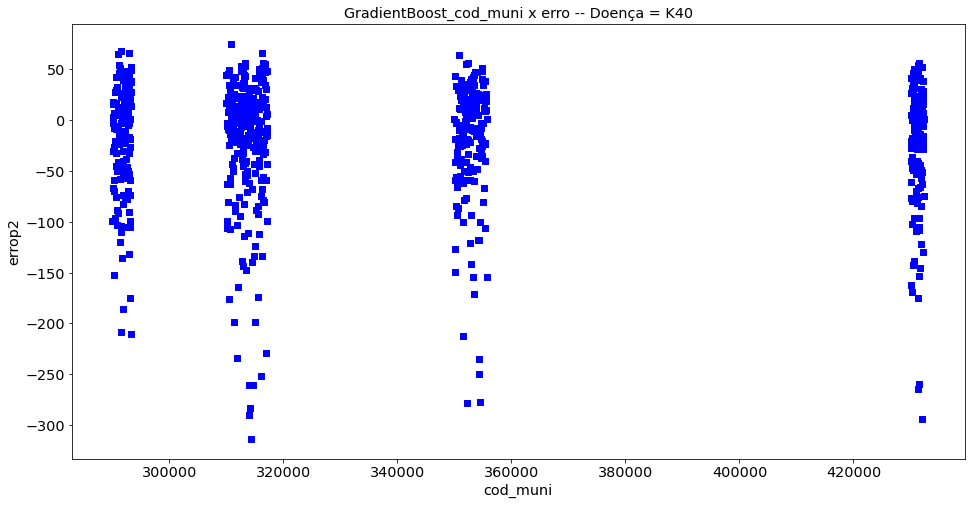

In [282]:
plt.scatter(X_test['cod_muni'], errop2, c = "blue", marker = "s")
plt.title("GradientBoost_cod_muni x erro -- Doença = K40")
plt.xlabel("cod_muni")
plt.ylabel("errop2")
plt.show()

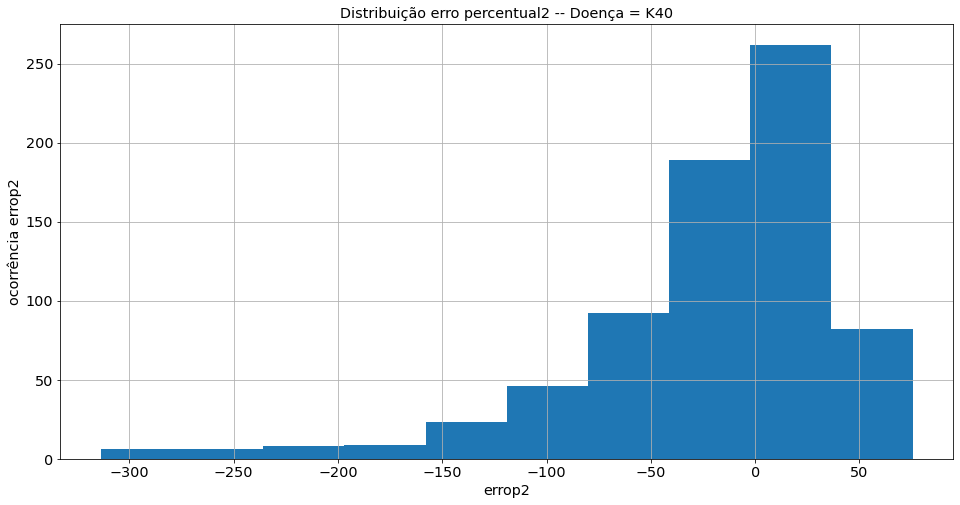

In [283]:
errop2.hist()
plt.title("Distribuição erro percentual2 -- Doença = K40")
plt.xlabel("errop2")
plt.ylabel("ocorrência errop2")
plt.show()

### XGBoosting

In [284]:
from xgboost import XGBRegressor
m_xgb_1= XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1,
             max_delta_step=0, max_depth=4, min_child_weight=1,
             min_child_weigth=7, missing=0.001, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [285]:
m_xgb_1.fit(X_train,y_train)

[23:34:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_child_weigth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=1, min_child_weigth=7, missing=0.001,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [286]:
y_pred_xgb_1= m_xgb_1.predict(X_test)

In [287]:
mse_xgb_1 = round(mean_squared_error(y_test, y_pred_xgb_1),8)
print (mse_xgb_1)

4.65e-06


In [288]:
errop2= (y_test - y_pred_xgb_1)*100/y_test
# em porcentagem

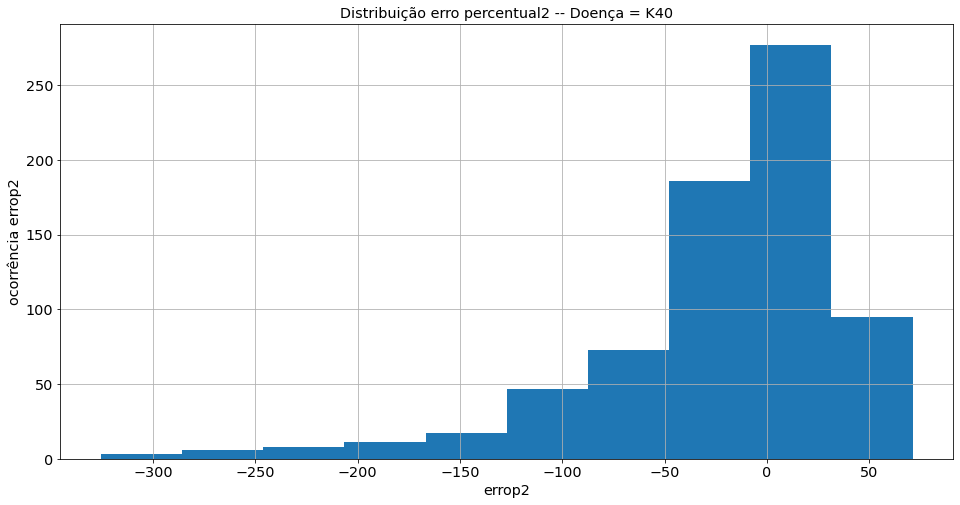

In [289]:
errop2.hist()
plt.title("Distribuição erro percentual2 -- Doença = K40")
plt.xlabel("errop2")
plt.ylabel("ocorrência errop2")
plt.show()

In [290]:
# Usando parâmetros de arquivo anterior
from xgboost import XGBRegressor
m_xgb_2= XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=0.001, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=42, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [291]:
m_xgb_2.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=0.001, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=42, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [292]:
y_pred_xgb_2= m_xgb_2.predict(X_test)

In [293]:
mse_xgb_2 = round(mean_squared_error(y_test, y_pred_xgb_2),8)
print(mse_xgb_2)

5.03e-06


In [294]:
errop2= (y_test - y_pred_xgb_2)*100/y_test
# em porcentagem
media=np.mean(errop2)
desvio=np.std(errop2)
print(media, desvio)

-21.35650592832085 63.91948927762171


### Identificação dos municípios com erro percentual entre -3 & 3 porcento -- XGBoosting

In [295]:
frame = { 'cod_muni': X_test['cod_muni'], "errop2": errop2 } 
result = pd.DataFrame(frame) 

In [296]:
a=result[result['errop2'] >-3]

In [297]:
b_rf=a[a['errop2'] <3]

In [298]:
b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 79086 to 59033
Data columns (total 2 columns):
cod_muni    35 non-null int64
errop2      35 non-null float64
dtypes: float64(1), int64(1)
memory usage: 840.0 bytes


In [299]:
b.head(35)

,cod_muni,errop2
79086,351220,-1.366356
83426,351780,-0.277848
88296,352380,1.000170
81258,351510,-0.797354
54635,314880,-0.994240
120717,430655,1.730246
93047,353020,-1.498908
136284,432000,0.336745
746,290130,-0.596848
98420,353760,-1.338822


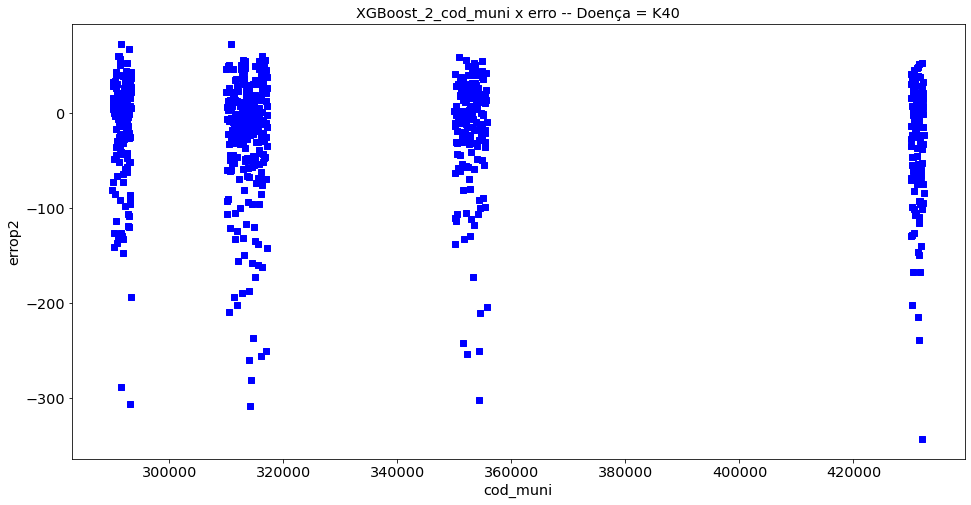

In [300]:
plt.scatter(X_test['cod_muni'], errop2, c = "blue", marker = "s")
plt.title("XGBoost_2_cod_muni x erro -- Doença = K40")
plt.xlabel("cod_muni")
plt.ylabel("errop2")
plt.show()

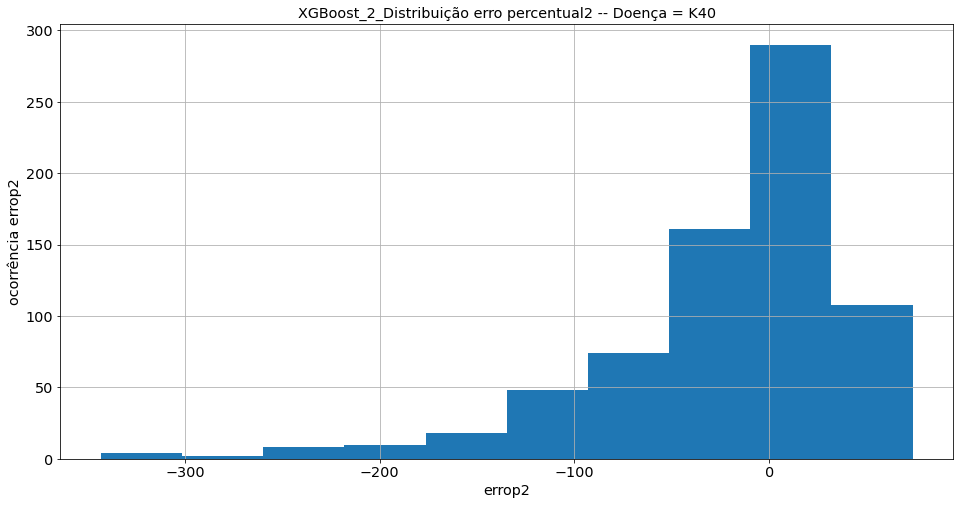

In [301]:
errop2.hist()
plt.title("XGBoost_2_Distribuição erro percentual2 -- Doença = K40")
plt.xlabel("errop2")
plt.ylabel("ocorrência errop2")
plt.show()

### Adaptative Boosting

In [302]:
m_ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=4,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.1, loss='linear', n_estimators=40,
                  random_state=None)

In [303]:
m_ada.fit(X_train,y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=4,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.1, loss='linear', n_estimators=40,
                  random_s

In [304]:
y_pred_ada = m_ada.predict(X_test)

In [305]:
mse_ada = round(mean_squared_error(y_test, y_pred_ada),8)
print (mse_ada)

4.77e-06


In [306]:
errop2= (y_test - y_pred_ada)*100/y_test
# em porcentagem

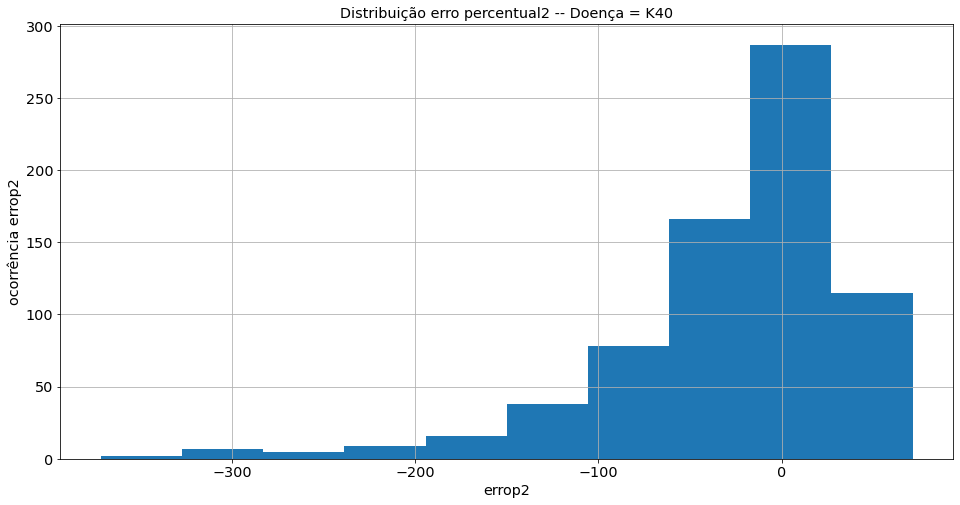

In [307]:
errop2.hist()
plt.title("Distribuição erro percentual2 -- Doença = K40")
plt.xlabel("errop2")
plt.ylabel("ocorrência errop2")
plt.show()

### Reavaliação das Métricas - uso de acurácia (aplicação relativa)

In [308]:
models=['Random_Forest','GradientBoost','LightGBM','XGBoost_1','XGBoost_2','AdaBoost']
mse=[mse_rf,mse_gbr,mse_lgb,mse_xgb_1,mse_xgb_2,mse_ada]
pd.DataFrame(list(zip(mse)), columns =['Mean Square Error'], index=models)

,Mean Square Error
Random_Forest,0.000005
GradientBoost,0.000005
LightGBM,0.000005
XGBoost_1,0.000005
XGBoost_2,0.000005
AdaBoost,0.000005


### Conclusão = Valores de erros baixos e próximos. Valores de acurácia com diferenças razoáveis. Aprofundar sintonia dos modelos.